# Препроцессинг данных перед передачей в модель

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
import torch

## Представление dicom в виде тензора 

In [1]:
!python scripts/prepare_ct_tensors.py  

Found 6 studies in ../data/processed/train
[1/6] Processing 01-0 ...
  Saved data/data_tensors/studies/01-0_lungs.pt
  Saved data/data_tensors/studies/01-0_mediastinum.pt
  Saved data/data_tensors/studies/01-0_bones.pt
[2/6] Processing 02-0 ...
  Saved data/data_tensors/studies/02-0_lungs.pt
  Saved data/data_tensors/studies/02-0_mediastinum.pt
  Saved data/data_tensors/studies/02-0_bones.pt
[3/6] Processing 03-0 ...
  Saved data/data_tensors/studies/03-0_lungs.pt
  Saved data/data_tensors/studies/03-0_mediastinum.pt
  Saved data/data_tensors/studies/03-0_bones.pt
[4/6] Processing 04-1 ...
  Saved data/data_tensors/studies/04-1_lungs.pt
  Saved data/data_tensors/studies/04-1_mediastinum.pt
  Saved data/data_tensors/studies/04-1_bones.pt
[5/6] Processing 05-1 ...
  Saved data/data_tensors/studies/05-1_lungs.pt
  Saved data/data_tensors/studies/05-1_mediastinum.pt
  Saved data/data_tensors/studies/05-1_bones.pt
[6/6] Processing 06-1 ...
  Saved data/data_tensors/studies/06-1_lungs.pt
  S

## Визуализация

In [8]:
# Загрузка ваших тензоров
tensors = {
    'lungs': torch.load('data/data_tensors/studies/01-0_lungs.pt'),      # (batch_size, 1, 64, 224, 224)
    'mediastinum': torch.load('data/data_tensors/studies/01-0_mediastinum.pt'),
    'bones': torch.load('data/data_tensors/studies/01-0_bones.pt')
}

In [9]:
# Визуализация первого примера из батча
sample_idx = 0
lungs_sample = tensors['lungs'][sample_idx, 0]  # (64, 224, 224)
mediastinum_sample = tensors['mediastinum'][sample_idx, 0]
bones_sample = tensors['bones'][sample_idx, 0]

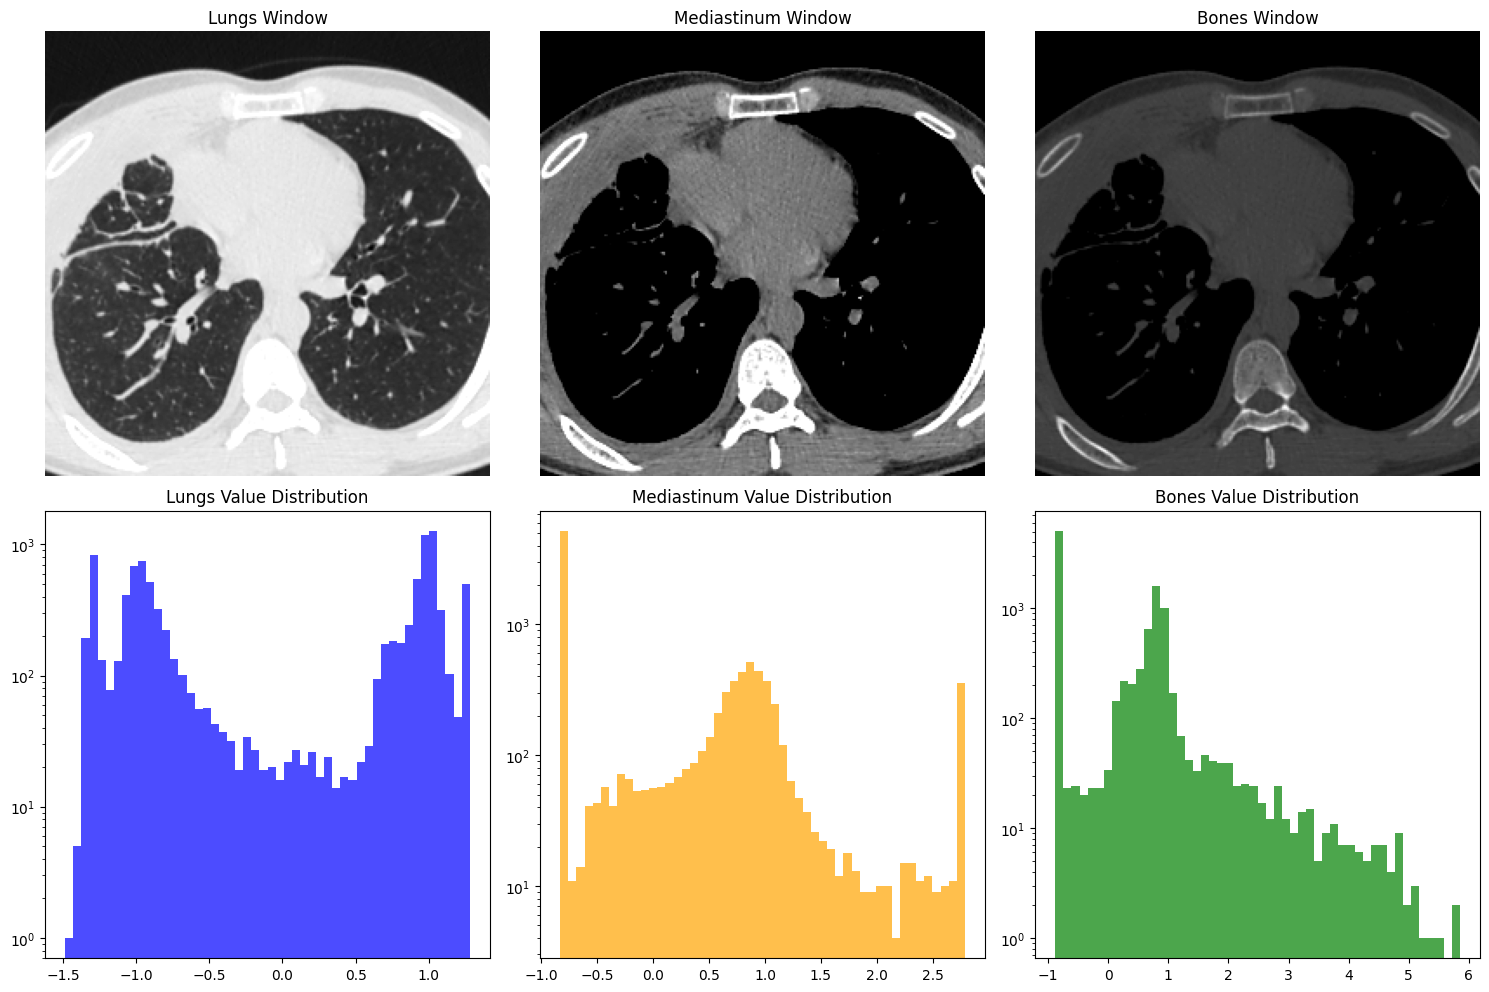

In [22]:
def compare_windows_fast(lungs, mediastinum, bones, sample_slices=5):
    """Быстрое сравнение окон с уменьшением детализации"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Берем только каждый N-ый срез для ускорения
    slice_indices = np.linspace(0, lungs.shape[1] - 1, sample_slices, dtype=int)
    
    # Визуализация средних срезов
    mid_slice = lungs.shape[1] // 2
    
    axes[0, 0].imshow(lungs[0, mid_slice, :, :], cmap='gray')
    axes[0, 0].set_title('Lungs Window')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(mediastinum[0, mid_slice, :, :], cmap='gray')
    axes[0, 1].set_title('Mediastinum Window')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(bones[0, mid_slice, :, :], cmap='gray')
    axes[0, 2].set_title('Bones Window')
    axes[0, 2].axis('off')
    
    # Быстрые гистограммы с семплированием
    sample_size = 10000  # Ограничиваем количество точек для гистограмм
    
    for i, (tensor, name, color) in enumerate(zip(
        [lungs, mediastinum, bones],
        ['Lungs', 'Mediastinum', 'Bones'],
        ['blue', 'orange', 'green']
    )):
        data = tensor.flatten()
        if len(data) > sample_size:
            data = data[::len(data)//sample_size]  # Простое семплирование
        
        axes[1, i].hist(data.cpu().numpy(), bins=50, alpha=0.7, color=color)
        axes[1, i].set_title(f'{name} Value Distribution')
        axes[1, i].set_yscale('log')  # Логарифмическая шкала для лучшего обзора
    
    plt.tight_layout()
    plt.show()

# Быстрая версия
compare_windows_fast(tensors['lungs'][sample_idx:sample_idx+1], 
                    tensors['mediastinum'][sample_idx:sample_idx+1], 
                    tensors['bones'][sample_idx:sample_idx+1])

# Сравнение 

In [10]:
def analyze_tensor_statistics(tensor_dict):
    """Анализ статистики тензоров"""
    print("=== ТЕНЗОРНАЯ СТАТИСТИКА ===")
    for name, tensor in tensor_dict.items():
        print(f"\n{name.upper()}:")
        print(f"  Shape: {tensor.shape}")
        print(f"  Min: {tensor.min():.4f}")
        print(f"  Max: {tensor.max():.4f}")
        print(f"  Mean: {tensor.mean():.4f}")
        print(f"  Std: {tensor.std():.4f}")
        print(f"  NaN values: {torch.isnan(tensor).sum().item()}")
        print(f"  Zero values: {(tensor == 0).sum().item()}")

In [21]:
analyze_tensor_statistics(tensors)

=== ТЕНЗОРНАЯ СТАТИСТИКА ===

LUNGS:
  Shape: torch.Size([1, 128, 256, 256])
  Min: -1.7939
  Max: 1.2803
  Mean: -0.0000
  Std: 1.0000
  NaN values: 0
  Zero values: 0

MEDIASTINUM:
  Shape: torch.Size([1, 128, 256, 256])
  Min: -0.8286
  Max: 2.7852
  Mean: 0.0000
  Std: 1.0000
  NaN values: 0
  Zero values: 0

BONES:
  Shape: torch.Size([1, 128, 256, 256])
  Min: -0.8789
  Max: 5.9453
  Mean: 0.0000
  Std: 1.0000
  NaN values: 0
  Zero values: 0


In [12]:
# Визуализация первого примера из батча
sample_idx = 0
lungs_sample = tensors['lungs'][sample_idx, 0]  # (64, 224, 224)
mediastinum_sample = tensors['mediastinum'][sample_idx, 0]
bones_sample = tensors['bones'][sample_idx, 0]